In [11]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
from gpflow.utilities import print_summary
import pandas as pd
gpflow.config.set_default_summary_fmt("notebook")
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D

# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot


In [38]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_md_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None, savepath = None):
        self._datapath = datapath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, condition = None, number = None,
                           columns = None,
                           ranges = None,
                           normalization = None,
                           validation_frac = None):
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (columns == None) or (ranges == None): 
            raise Warning(f'$columns$ and $ranges$ must be given')
        
        if (validation_frac == None):
            warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
            validation_frac = 0.2
    
        all_files = glob.glob(self._datapath + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = []
            df0 = self.get_data_of_a_track(filename = filename, 
                                           columns = columns,
                                           ranges = ranges,
                                           normalization =normalization)
            df1.append(df0)
            
        df = pd.concat(df1, ignore_index=True)
        
        random_state = 1

        if (len(df['type'])*(1 - validation_frac) >= 10000):
            train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        else:
            train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, columns = None, ranges = None, normalization = None):
        '''
        '''        
        one_track = []
        one_track = pd.read_csv(filename)
                
        #get rid of the pre-MS
        one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        one_track['type'] = 'vali'
        one_track['frac_age'] = one_track['star_age']*0.0
        one_track['m_age'] = one_track['star_age']*0.0
        
        for i in range(len(columns)):
            #print(columns[i], ranges[i])
            temp = None
            temp = one_track[(one_track[columns[i]] >= min(ranges[i])) & (one_track[columns[i]] <= max(ranges[i]))]
            if (temp.shape[0] >= 10):
                one_track = one_track.loc[temp.index.min(): temp.index.max()]
                one_track['frac_age'] = one_track['star_age']/np.median(one_track['star_age'])
                one_track['m_age'] = one_track['star_age']*0.0 + np.median(one_track['star_age'])
            else:
                one_track = None
                break
            if (normalization != None):
                if (normalization[i] > -999):
                    one_track[columns[i]] = one_track[columns[i]]/normalization[i]
        return one_track
    
    ##################### Plot section########################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    def plot_3d_data(self, x = None, y = None, z = None, c = None):
        fig = plt.figure()
        ax = Axes3D(fig)
        cp = ax.scatter(x, y, z, c = c, s=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        colorbar = plt.colorbar(cp)
        colorbar.set_label('c')
        return ax, colorbar 
    
    
   
      #####################Data generating#################
    def generate_2d_surface(self, xv = None, xvstep = None, xf1 = None, xf2 = None, number = None, factor = None):
    
        new_xv = []
        new_xf1 = []
        new_xf2 = []
    
        if factor == None: factor = 10
        
        number = min([factor*len(xv), number])
    
        for i in range(int(factor)):
            aa = xv + xvstep*(np.random.random(len(xv))-0.5)
            new_xv = np.concatenate((new_xv, aa))
            new_xf1 = np.concatenate((new_xf1, xf1))
            new_xf2 = np.concatenate((new_xf2, xf2))
            if (len(new_xv) >= number): break
    
        idxs = np.random.choice(arange(len(new_xv)), number)                           
        return new_xv[idxs], new_xf1[idxs], new_xf2[idxs]
    
    ######################GP models##################
    def gp_model(self, xx, y):
        gpflow.config.set_default_positive_minimum(1e-6)
        k = gpflow.kernels.Matern12()
        
        m = gpflow.models.GPR(data=(xx, y), kernel=k, mean_function=None)

        # optimise hyper-parameters
        opt = gpflow.optimizers.Scipy()

        def objective_closure():
            return - m.log_marginal_likelihood()

        opt_logs = opt.minimize(objective_closure,
                                m.trainable_variables,
                                options=dict(maxiter=1000)
                               )
        return m
    


# global_kernel 
# Here we try GP-3D, says p = f(mass, age, Fe/H) 

# set up path

In [39]:
datadr = '/Users/litz/Documents/GitHub/data/simple_grid_alex/'
savedr = '/Users/litz/Documents/GitHub/GPflow/test4-md-GP/'

In [40]:
gmk = global_md_kernel()
gmk.set_path(datapath = datadr, savepath = savedr)


Data path is set as/Users/litz/Documents/GitHub/data/simple_grid_alex/
Save path is set as/Users/litz/Documents/GitHub/GPflow/test4-md-GP/


# set up fundimential inputs and observables

In [41]:
fundimential = ['initial_mass','initial_feh','star_age']
observable = ['effective_T', 'log_g' 'star_feh', 'nu_0_19','nu_0_20','nu_0_21']
observable_value = [5777.0, 4.44, 0.0, 2764.142, 2899.022, 3033.754]
observable_error = [50.0, 0.05,  0.05, 0.5, 0.5, 0.5]

# 1st we find out the ranges of input and outputs

In [143]:

columns = ['initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'ms_age',
           'effective_T',
           'log_g',
           'star_feh',
           'delta_nu',
           'nu_0_19',
           'nu_0_20',
           'nu_0_21']
ranges = [[0.0,1.6], 
          [0.0,1.0],
          [-0.2,0.3],
          [0.0,99.0],
          [-1.0e99, 1.0e99],
          [-1.0e99,1.0e99], 
          [(5777.0 - 10.0), (5777.0 + 10)],
          [4.34,4.54],
          [-0.5, 0.5],
          [(135.1 - 10), (135.1 + 10)],
          [2600,2900],
          [2800,3000],
          [2900,3100],
         ]

normalization = [-9999, -9999, -9999, -9999,-9999, -9999, 
                 5777.0, 4.44, -9999, 
                 135.1, 135.1, 135.1,135.1]

df = gmk.get_data_of_a_grid(condition = 'm*Y*FeH0.0MLT*ov0.0dif1.csv', number = None,
                           columns = columns,
                           ranges = ranges, 
                           normalization = normalization,  
                           validation_frac = 0.3)
df.to_csv(savedr + 'df.csv')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: $number$ is missing, all file will be used


1007 tracks are found
the columns names are['initial_mass', 'initial_Yinit', 'initial_feh', 'initial_MLT', 'star_age', 'ms_age', 'effective_T', 'log_g', 'star_feh', 'delta_nu', 'nu_0_19', 'nu_0_20', 'nu_0_21']


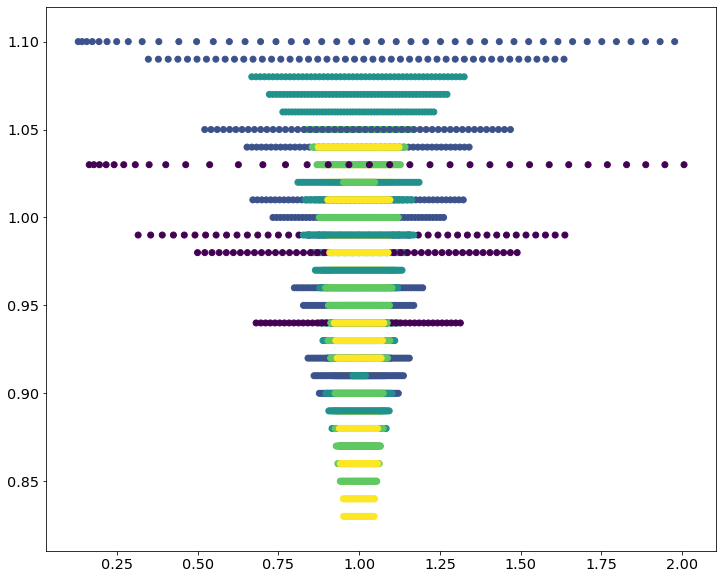

In [144]:
plt.scatter(df['frac_age'], df['initial_mass'], c = df['initial_MLT'])

# In test2 we failed to train 3D data derictly (teff = f(m, t, Z)) because the density in 3D space is not good enough. Moreover, we have proved that GP works fairly well for 2D surface. 
# So we change the procedure as follow: 
# 1. GP 2D surface p = f(m,t) for each feh
# 2. Useing these 2D GP models to sample data in 3D space
# 3. Train 3D GP.... 

# we plot Teff-Mass-Age surface of the model grid.  It can be seen that the grid is uniformly spaced.

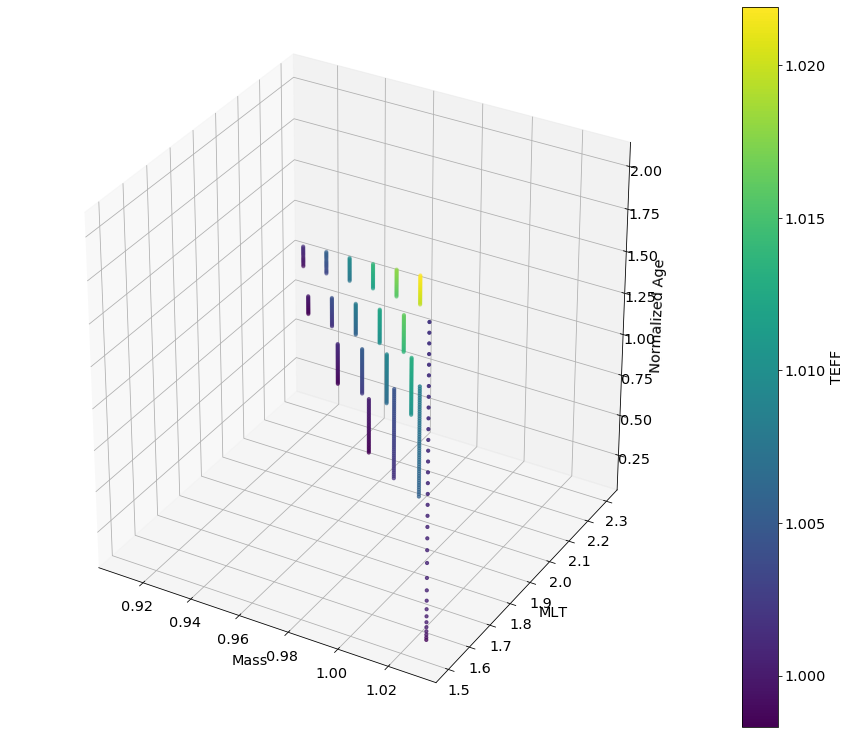

In [145]:
idex = df['initial_Yinit'] == 0.28
ax, colorbar = gmk.plot_3d_data(x = df['initial_mass'][idex], 
                      z = df['frac_age'][idex],
                      c = df['effective_T'][idex],
                      y = df['initial_MLT'][idex])
ax.set_xlabel('Mass')
ax.set_zlabel('Normalized Age')
ax.set_ylabel('MLT')
colorbar.set_label('TEFF')
plt.savefig(savedr + "grid_models.png")

# step 1: we train GP models for 2 inputs-1 ouputs P = f(mass, age) for each FeH. We have three outputs, namely, Teff, delta_nu, and nu_0_10
# Step 2: we resample data with these GP models

In [146]:
yinits = np.linspace(0.24,0.32,5)
mlts = np.linspace(1.5,2.3,5)
yinits, mlts

(array([0.24, 0.26, 0.28, 0.3 , 0.32]), array([1.5, 1.7, 1.9, 2.1, 2.3]))

In [147]:
df_l2 = pd.concat([df,df], ignore_index=True)
df_l2['initial_mass'] = df_l2['initial_mass']+ 0.02*(np.random.random(len(df_l2))-0.5)
df_l2['frac_age'] = df_l2['frac_age']+ 0.00*(np.random.random(len(df_l2))-0.5)

df_l2

,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_age,ms_age,effective_T,log_g,star_feh,delta_nu,nu_0_19,nu_0_20,nu_0_21,type,frac_age,m_age
0,0.939149,0.30,0.0,1.9,3.192667,7.754780,1.008973,1.000669,-0.056462,1.071008,20.864417,21.891807,22.918262,data,0.875888,3.645063
1,0.939354,0.30,0.0,1.9,3.214418,7.754780,1.009035,1.000506,-0.056849,1.069711,20.838198,21.864375,22.889563,data,0.881855,3.645063
2,0.932911,0.30,0.0,1.9,3.236148,7.754780,1.009097,1.000342,-0.057248,1.068411,20.811924,21.836876,22.860809,data,0.887817,3.645063
3,0.941795,0.30,0.0,1.9,3.257858,7.754780,1.009158,1.000179,-0.057644,1.067111,20.785659,21.809385,22.832061,data,0.893773,3.645063
4,0.941825,0.30,0.0,1.9,3.279547,7.754780,1.009219,1.000015,-0.058038,1.065811,20.759392,21.781892,22.803309,data,0.899723,3.645063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,1.021716,0.28,0.0,1.5,0.574555,6.243062,1.001836,0.997949,-0.018270,1.021159,19.854406,20.833676,21.818800,data,1.768302,0.324919
6656,1.033244,0.28,0.0,1.5,0.593880,6.243062,1.001891,0.997799,-0.018920,1.020008,19.831091,20.809303,21.793351,data,1.827776,0.324919
6657,1.028295,0.28,0.0,1.5,0.613166,6.243062,1.001944,0.997650,-0.019565,1.018861,19.807875,20.785029,21.768007,data,1.887134,0.324919
6658,1.022439,0.28,0.0,1.5,0.632426,6.243062,1.001998,0.997501,-0.020206,1.017718,19.784736,20.760834,21.742746,data,1.946409,0.324919


In [148]:
start_time = time.time()

def generate_gp_data(xx, y, xx_new):
    gpm = gmk.gp_model(xx, y)
    y_new, y_new_var = gpm.predict_f(xx_new)
    return y_new.numpy().reshape(len(y_new),) 

for yinit in yinits:
    for mlt in mlts: 
        yinit = round(yinit, 2)
        mlt = round(mlt, 1)
        print('Yinit = ' + str(yinit) + ' MLT = ' + str(mlt))
    
        idexs = ((df['initial_Yinit'] == yinit) & (df['initial_MLT'] == mlt))
        idexs_l2 = ((df_l2['initial_Yinit'] == yinit) & (df_l2['initial_MLT'] == mlt))
    
        x1 = df['initial_mass'][idexs].to_numpy()
        x2 = df['frac_age'][idexs].to_numpy()
        x3 = df['initial_Yinit'][idexs].to_numpy()
    
        xx = np.column_stack([[x1, x2]]).T
    
        x1_new = df_l2['initial_mass'][idexs_l2].to_numpy()
        x2_new = df_l2['frac_age'][idexs_l2].to_numpy()
        x3_new = df_l2['initial_Yinit'][idexs_l2].to_numpy()
    
        xx_new = np.column_stack([[x1_new, x2_new]]).T
    
        y1 = df['effective_T'][idexs].to_numpy().reshape(-1, 1)
        y2 = df['delta_nu'][idexs].to_numpy().reshape(-1, 1)
        y3 = df['star_feh'][idexs].to_numpy().reshape(-1, 1)

        print('size of the array for yinit/mlt = ' + str(yinit) + str(mlt), y1.size)

        df_l2['effective_T'][idexs_l2] = generate_gp_data(xx, y1, xx_new)
        df_l2['delta_nu'][idexs_l2] = generate_gp_data(xx, y2, xx_new)
        df_l2['star_feh'][idexs_l2] = generate_gp_data(xx, y3, xx_new)

print("--- %s seconds ---" % (time.time() - start_time))

df_l2.to_csv(savedr + 'df_l2.csv')

Yinit = 0.24 MLT = 1.5
size of the array for yinit/mlt = 0.241.5 0
Yinit = 0.24 MLT = 1.7
size of the array for yinit/mlt = 0.241.7 90


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Yinit = 0.24 MLT = 1.9
size of the array for yinit/mlt = 0.241.9 177
Yinit = 0.24 MLT = 2.1
size of the array for yinit/mlt = 0.242.1 166
Yinit = 0.24 MLT = 2.3
size of the array for yinit/mlt = 0.242.3 230
Yinit = 0.26 MLT = 1.5
size of the array for yinit/mlt = 0.261.5 0
Yinit = 0.26 MLT = 1.7
size of the array for yinit/mlt = 0.261.7 99
Yinit = 0.26 MLT = 1.9
size of the array for yinit/mlt = 0.261.9 97
Yinit = 0.26 MLT = 2.1
size of the array for yinit/mlt = 0.262.1 138
Yinit = 0.26 MLT = 2.3
size of the array for yinit/mlt = 0.262.3 240
Yinit = 0.28 MLT = 1.5
size of the array for yinit/mlt = 0.281.5 34
Yinit = 0.28 MLT = 1.7
size of the array for yinit/mlt = 0.281.7 133
Yinit = 0.28 MLT = 1.9
size of the array for yinit/mlt = 0.281.9 181
Yinit = 0.28 MLT = 2.1
size of the array for yinit/mlt = 0.282.1 198
Yinit = 0.28 MLT = 2.3
size of the array for yinit/mlt = 0.282.3 228
Yinit = 0.3 MLT = 1.5
size of the array for yinit/mlt = 0.31.5 90
Yinit = 0.3 MLT = 1.7
size of the array fo

# The new data generated by 2I-1O models are shown below. 

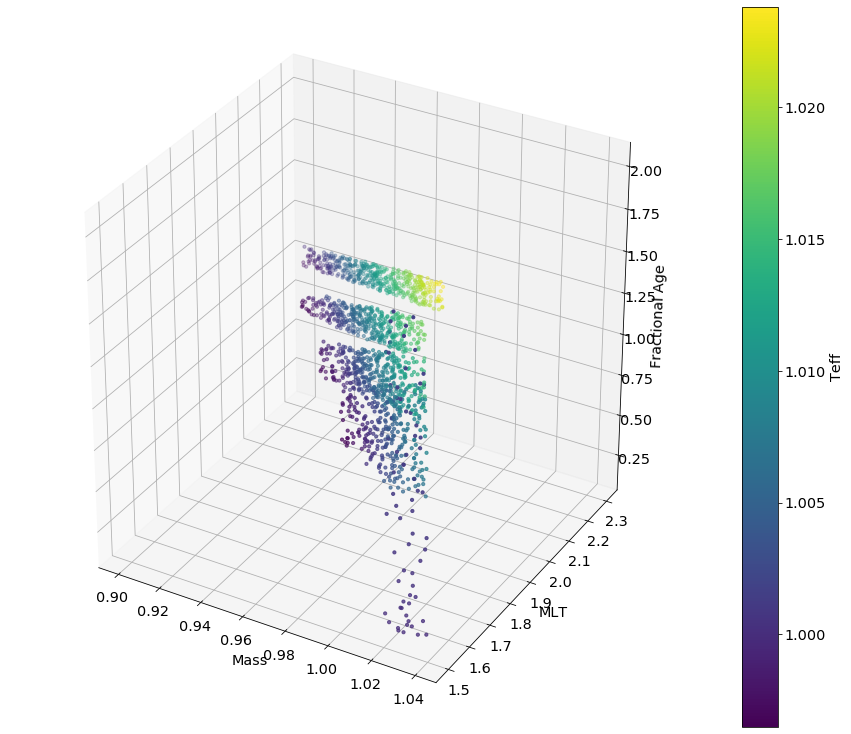

In [149]:
idex = df_l2['initial_Yinit'] == 0.28
ax, colorbar = gmk.plot_3d_data(x = df_l2['initial_mass'][idex], 
                      z = df_l2['frac_age'][idex],
                      c = df_l2['effective_T'][idex],
                      y = df_l2['initial_MLT'][idex])
ax.set_xlabel('Mass')
ax.set_zlabel('Fractional Age')
ax.set_ylabel('MLT')
colorbar.set_label('Teff')

plt.savefig(savedr + "gp_level2.png")

# step 3: Now we use the new samples to GP teff = f(mass, age, MLT). It takes a couple hours on my laptop

In [150]:
df_l3 = pd.concat([df,df], ignore_index=True)
df_l3['frac_age'] = df_l3['frac_age']+ 0.0*(np.random.random(len(df_l3))-0.5)
df_l3['initial_mass'] = df_l3['initial_mass']+ 0.02*(np.random.random(len(df_l3))-0.5)
df_l3['initial_MLT'] = df_l3['initial_MLT']+ 0.2*(np.random.random(len(df_l3))-0.5)

df_l3 = df_l3[((df_l3['initial_MLT'] >=1.7) & (df_l3['initial_MLT'] <=2.3))]
df_l3

,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_age,ms_age,effective_T,log_g,star_feh,delta_nu,nu_0_19,nu_0_20,nu_0_21,type,frac_age,m_age
0,0.931286,0.30,0.0,1.899088,3.192667,7.75478,1.008973,1.000669,-0.056462,1.071008,20.864417,21.891807,22.918262,data,0.875888,3.645063
1,0.931058,0.30,0.0,1.914442,3.214418,7.75478,1.009035,1.000506,-0.056849,1.069711,20.838198,21.864375,22.889563,data,0.881855,3.645063
2,0.933715,0.30,0.0,1.999253,3.236148,7.75478,1.009097,1.000342,-0.057248,1.068411,20.811924,21.836876,22.860809,data,0.887817,3.645063
3,0.942249,0.30,0.0,1.911729,3.257858,7.75478,1.009158,1.000179,-0.057644,1.067111,20.785659,21.809385,22.832061,data,0.893773,3.645063
4,0.941726,0.30,0.0,1.957791,3.279547,7.75478,1.009219,1.000015,-0.058038,1.065811,20.759392,21.781892,22.803309,data,0.899723,3.645063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6614,0.989577,0.26,0.0,2.287547,5.625392,9.18822,1.011166,0.996465,-0.070434,1.029658,20.071022,21.053356,22.038023,vali,1.042801,5.394504
6617,0.973873,0.26,0.0,2.220795,5.694343,9.18822,1.011347,0.995939,-0.071269,1.025663,19.990423,20.968924,21.949685,vali,1.055582,5.394504
6619,0.972042,0.26,0.0,2.205328,5.740234,9.18822,1.011465,0.995587,-0.071822,1.022994,19.936578,20.912511,21.890665,data,1.064089,5.394504
6620,0.972204,0.26,0.0,2.257893,5.763157,9.18822,1.011523,0.995410,-0.072098,1.021657,19.909625,20.884270,21.861118,data,1.068339,5.394504


In [151]:
start_time = time.time()

def generate_gp_data(xx, y, xx_new):
    stime = time.time()
    gpm = gmk.gp_model(xx, y)
    y_new, y_new_var = gpm.predict_f(xx_new)
    print("--- %s seconds ---" % (time.time() - stime))
    return gpm, y_new.numpy().reshape(len(y_new),) 

for yinit in yinits:
    yinit = round(yinit, 2)
    print('Yinit = ' + str(yinit))
    
    idexs_l2 = df_l2['initial_Yinit'] == yinit
    idexs_l3 = df_l3['initial_Yinit'] == yinit
    
    x1 = df_l2['initial_mass'][idexs_l2].to_numpy()
    x2 = df_l2['frac_age'][idexs_l2].to_numpy()
    x3 = df_l2['initial_MLT'][idexs_l2].to_numpy()
    
    xx = np.column_stack([[x1, x2, x3]]).T
    
    x1_new = df_l3['initial_mass'][idexs_l3].to_numpy()
    x2_new = df_l3['frac_age'][idexs_l3].to_numpy()
    x3_new = df_l3['initial_MLT'][idexs_l3].to_numpy()
    
    xx_new = np.column_stack([[x1_new, x2_new, x3_new]]).T
    
    y1 = df_l2['effective_T'][idexs_l2].to_numpy().reshape(-1, 1)
    y2 = df_l2['delta_nu'][idexs_l2].to_numpy().reshape(-1, 1)
    y3 = df_l2['star_feh'][idexs_l2].to_numpy().reshape(-1, 1)

    print('size of the array for Yinit = ' + str(yinit), y1.size)

    m3_teff, df_l3['effective_T'][idexs_l3] = generate_gp_data(xx, y1, xx_new)
    m3_dnu, df_l3['delta_nu'][idexs_l3] = generate_gp_data(xx, y2, xx_new)
    m3_sterfeh, df_l3['star_feh'][idexs_l3] = generate_gp_data(xx, y3, xx_new)

print("--- %s seconds ---" % (time.time() - start_time))
df_l3.to_csv(savedr + 'df_l3.csv')

Yinit = 0.24
size of the array for Yinit = 0.24 1326
--- 25.33895492553711 seconds ---
--- 28.17055106163025 seconds ---
--- 21.775525093078613 seconds ---
Yinit = 0.26
size of the array for Yinit = 0.26 1148
--- 17.819665908813477 seconds ---


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--- 18.967323303222656 seconds ---


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


--- 14.368597030639648 seconds ---
Yinit = 0.28
size of the array for Yinit = 0.28 1548


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KeyboardInterrupt: 

# now let us look at GP predictions.

# GP seems to do good job for predicting teff.

# Now let us train delta_nu with the same procedure (it takes another couple hours)

# Look! 3D GP models are able to mimic the evolutaionary tracks on HRD.

In [ ]:
idex = df_l3['initial_Yinit'] == 0.28
ax, colorbar = gmk.plot_3d_data(x = df_l3['initial_mass'][idex], 
                      z = df_l3['frac_age'][idex],
                      c = df_l3['effective_T'][idex],
                      y = df_l3['initial_MLT'][idex])
ax.set_xlabel('Mass')
ax.set_zlabel('Fractional Age')
ax.set_ylabel('MLT')
colorbar.set_label('Teff')

plt.savefig(savedr + "gp_level3.png")

In [ ]:
# 4-D GP teff = f(mass, age, Yinit, alpha_MLT)

In [ ]:
df_l4 = pd.concat([df,df,df,df,df,df,df,df], ignore_index=True)
df_l4['frac_age'] = df_l4['frac_age']+ 0.0*(np.random.random(len(df_l4))-0.5)
df_l4['initial_mass'] = df_l4['initial_mass']+ 0.02*(np.random.random(len(df_l4))-0.5)
df_l4['initial_MLT'] = df_l4['initial_MLT']+ 0.2*(np.random.random(len(df_l4))-0.5)
df_l4['initial_Yinit'] = df_l4['initial_Yinit']+ 0.02*(np.random.random(len(df_l4))-0.5)

df_l4= df_l4[( (df_l4['initial_MLT'] >= 1.7) & (df_l4['initial_MLT'] <=2.3)
             & (df_l4['initial_Yinit'] >= 0.24) & (df_l4['initial_Yinit'] <= 0.32)
             )]

In [ ]:
df_l4

In [ ]:
start_time = time.time()

def generate_gp_data(xx, y, xx_new):
    stime = time.time()
    gpm = gmk.gp_model(xx, y)
    y_new, y_new_var = gpm.predict_f(xx_new)
    print("--- %s seconds ---" % (time.time() - stime))
    return gpm, y_new.numpy().reshape(len(y_new),) 

for i in range(1):
    print(i)
    
    idexs_l3 = (df_l3['initial_Yinit'] >= 0.0)
    idexs_l4 = (df_l4['initial_Yinit'] >= 0.0)
    
    x1 = df_l3['initial_mass'][idexs_l3].to_numpy()
    x2 = df_l3['frac_age'][idexs_l3].to_numpy()
    x3 = df_l3['initial_MLT'][idexs_l3].to_numpy()
    x4 = df_l3['initial_Yinit'][idexs_l3].to_numpy()
    
    xx = np.column_stack([[x1, x2, x3, x4]]).T
    
    x1_new = df_l4['initial_mass'][idexs_l4].to_numpy()
    x2_new = df_l4['frac_age'][idexs_l4].to_numpy()
    x3_new = df_l4['initial_MLT'][idexs_l4].to_numpy()
    x4_new = df_l4['initial_Yinit'][idexs_l4].to_numpy()
    
    xx_new = np.column_stack([[x1_new, x2_new, x3_new, x4_new]]).T
    
    y1 = df_l3['effective_T'][idexs_l3].to_numpy().reshape(-1, 1)
    y2 = df_l3['delta_nu'][idexs_l3].to_numpy().reshape(-1, 1)
    y3 = df_l3['star_feh'][idexs_l3].to_numpy().reshape(-1, 1)

    print('size of the array', y1.size)

    m4_teff, df_l4['effective_T'][idexs_l4] = generate_gp_data(xx, y1, xx_new)
    m4_dnu, df_l4['delta_nu'][idexs_l4] = generate_gp_data(xx, y2, xx_new)
    m4_sterfeh, df_l4['star_feh'][idexs_l4] = generate_gp_data(xx, y3, xx_new)

print("--- %s seconds ---" % (time.time() - start_time))
df_l3.to_csv(savedr + 'df_l4.csv')

In [ ]:

x1_new = df_l4['initial_mass'].to_numpy()
x2_new = df_l4['frac_age'].to_numpy()
x3_new = df_l4['initial_MLT'].to_numpy()
x4_new = df_l4['initial_Yinit'].to_numpy()
    
xx_new = np.column_stack([[x1_new, x2_new, x3_new, x4_new]]).T

y_new, y_new_var = m4_teff.predict_f(xx_new)
df_l4['effective_T'] = y_new.numpy().reshape(len(y_new),) 

y_new, y_new_var = m4_dnu.predict_f(xx_new)
df_l4['delta_nu'] = y_new.numpy().reshape(len(y_new),) 

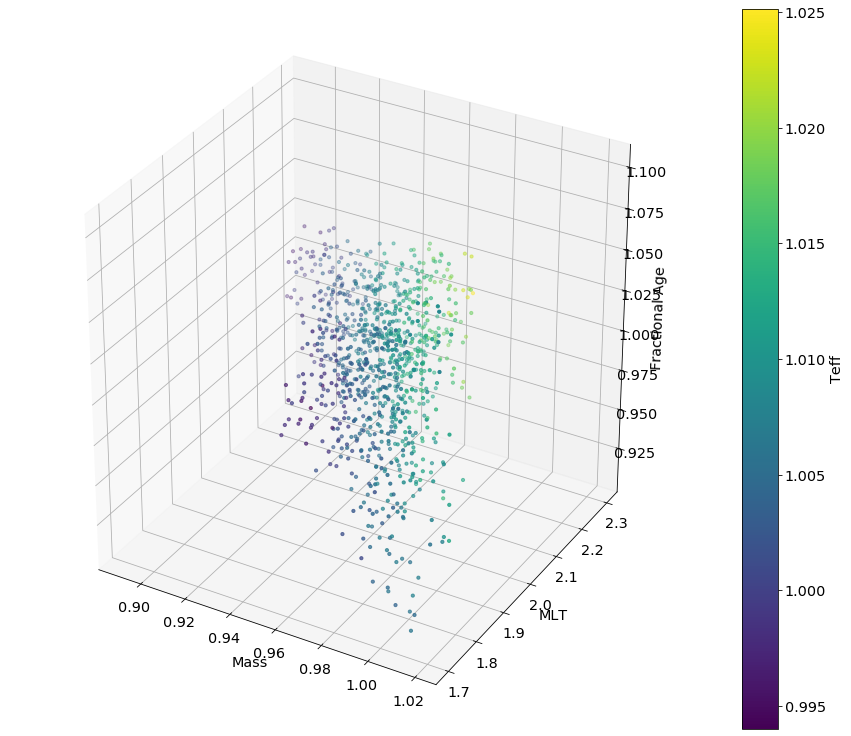

In [140]:
idex = (np.abs(df_l4['initial_Yinit'] - 0.28) <= 0.005)
ax, colorbar = gmk.plot_3d_data(x = df_l4['initial_mass'][idex], 
                      z = df_l4['frac_age'][idex],
                      c = df_l4['effective_T'][idex],
                      y = df_l4['initial_MLT'][idex])
ax.set_xlabel('Mass')
ax.set_zlabel('Fractional Age')
ax.set_ylabel('MLT')
colorbar.set_label('Teff')

plt.savefig(savedr + "gp_level4.png")

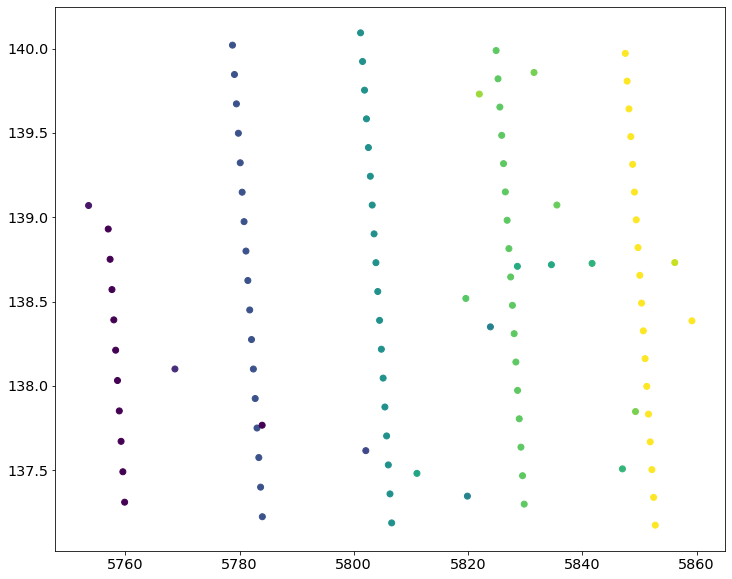

In [142]:
idexs = ((df['initial_MLT'] == 1.9) & (df['initial_Yinit'] == 0.28))
plt.scatter(df['effective_T'][idexs]*5777.0,df['delta_nu'][idexs]*135.1,c = df['initial_mass'][idexs])

idexs = ( (np.abs(df_l4['initial_MLT'] - 1.9) <= 0.005) & (np.abs(df_l4['initial_Yinit'] -0.28) <=0.005))
plt.scatter(df_l4['effective_T'][idexs]*5777.0,df_l4['delta_nu'][idexs]*135.1,c = df_l4['initial_mass'][idexs]) 

In [ ]:
print_summary(m4_teff)

In [ ]:
print_summary(m4_dnu)